In [1]:
import numpy as np
import matplotlib.pyplot as plt
from igraph import *
import pandas as pd
import requests

In [2]:
#os.chdir('../../')
os.getcwd()
arpack_options.maxiter=300000 # to solve a problem later about arpack too low

In [3]:
dismat = np.load('../Backend/static/npydata/cluster6/dismat.npy')

In [4]:
names = np.load('../Backend/static/npydata/cluster6/names_train.npy')

In [5]:
dismat.shape

(1815, 1815)

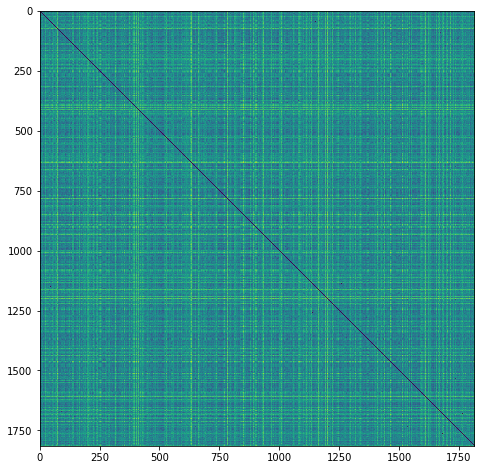

In [6]:
plt.figure(figsize=(8,8))
plt.imshow(dismat)
plt.show()

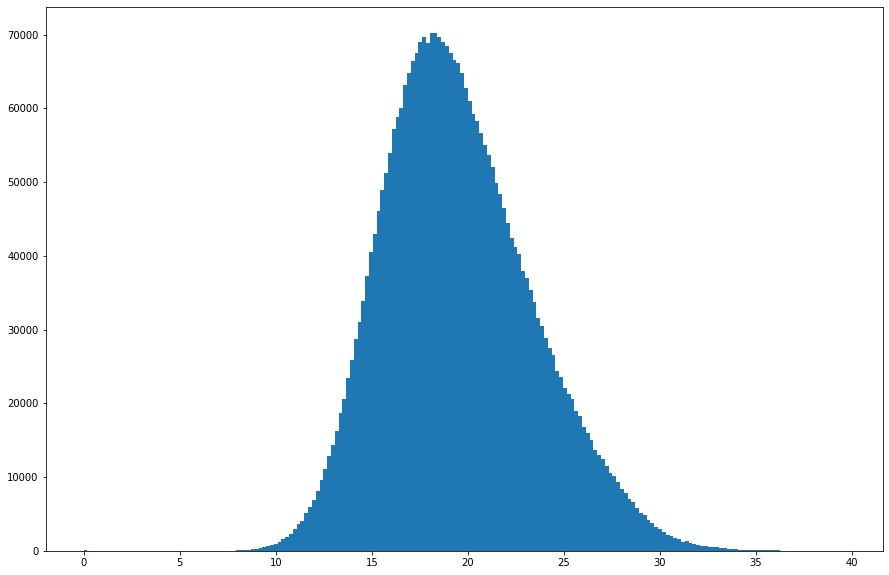

In [7]:
dismatflat = dismat.reshape((-1,))
dismatflat = dismat[dismat != 0] # Too many ones result in a bad histogram so we remove them
plt.figure(figsize=(15, 10))
_ = plt.hist(dismatflat, bins=200)

# 此处可以做归一化,但是最后决定不做,感觉可能会因此损失精度

In [160]:
adjmtx = dismat.copy()
#np.fill_diagonal(adjmtx, np.min(dismat[dismat > 0]))
#adjmtx = (dismat - np.min(adjmtx[adjmtx > 0])) / (np.max(adjmtx) - np.min(adjmtx[adjmtx > 0]))

In [161]:
np.min(dismat[dismat > 0])

2.3841858e-07

In [162]:
np.max(adjmtx) - np.min(adjmtx[adjmtx > 0])

39.61254

In [163]:
np.min(adjmtx[adjmtx > 0])

2.3841858e-07

In [164]:
np.fill_diagonal(adjmtx, 0)

In [167]:
drawdata = adjmtx.copy()
threshold = 9
drawdata[drawdata > threshold] = 0

# 根据degree 来筛掉一些点
> 但是实际上还是没有采用,因为只是感觉上有道理,也没有确切的理论支持,但是还是当做可选选项吧   
> 需要先做阈值筛选再做Degree的筛选

### 画出Degree 的分布

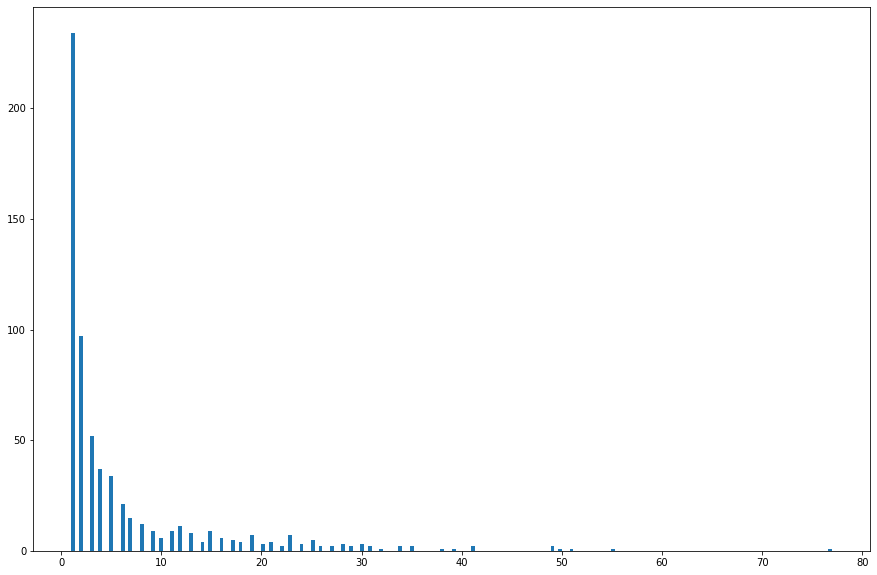

In [144]:
plt.figure(figsize=(15, 10))
_ = plt.hist([len([item for item in col if item > 0]) for col in drawdata if len([item for item in col if item > 0]) != 0], bins=200)

In [ ]:
### 

In [153]:
for i, item in enumerate(drawdata):
    if sum(drawdata[i] > 0) > 20: # 20 为 degree 的最高值
        drawdata[:, i:i+1] = 0
        drawdata[i:i+1, :] = 0

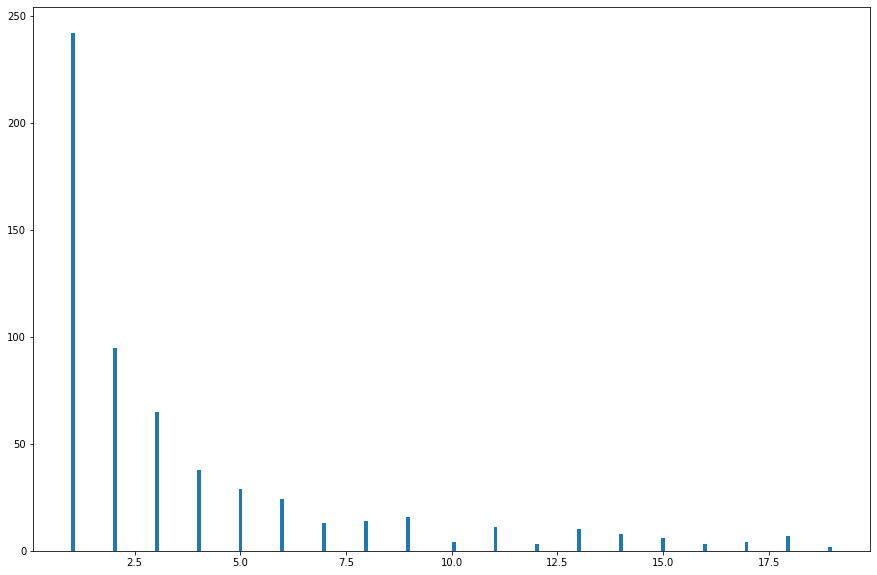

In [154]:
plt.figure(figsize=(15, 10))
_ = plt.hist([len([item for item in col if item > 0]) for col in drawdata if len([item for item in col if item > 0]) != 0], bins=200)

In [168]:
g = Graph.Adjacency((drawdata > 0).tolist(), "MAX")
g.es['weight'] = drawdata[drawdata > 0]
#g.vs['label'] = names.tolist()
g.vs['label'] = list(range(0, len(names)))

In [169]:
b = g.community_leading_eigenvector(weights=g.es["weight"])
b.summary()

'Clustering with 1815 elements and 1543 clusters'

In [99]:
g.ecount()

5343

In [100]:
os.getcwd()

'/home/gs/git-repos/nus'

In [ ]:
layout = g.layout("fr")
_ = plot(b, layout=layout,bbox=(0, 0, 1500, 1500), target="./try22.5.pdf")

In [57]:
import os
from shutil import copyfile

# 参数为0.036 / new 0.015

In [131]:
b.summary()

'Clustering with 1815 elements and 835 clusters'

In [2]:
# 根据index获得所在的cluster
def find_index_in_cluster(index):
    for i, cluster in enumerate(b):
            if index in cluster:
                print(str(i) + 'th cluster\n')
                print(names[index])
                print('\n\n')
                return names[index]
                #for item in cluster:
                #    print(names[item])

In [3]:
# 根据学校的名字返回其index
def find_school_index(name):
    return names.tolist().index(name + '_China')

In [4]:
# 列出某个cluster中的所有成员
def list_cluster(index):
    print(b[index])
    print([names[x][:-6] for x in b[index]])

# 转换格式
> 用于将CD算法之后的子图数据转化为3d-force-graph所使用的json数据格式

In [50]:
import json

In [51]:
def cluster_index(index):
    for i, cluster in enumerate(b):
            if index in cluster:
                return i

In [52]:
g.ecount()

9453

In [5]:
# 原本用于解决python zipfile解压时的中文乱码问题,随后用命令行解压来解决了这个问题,所以基本上用不到了
# def handle_encode(target):
#     if not target:
#         return target
#     if target.endswith('China') or target.endswith('Hong Kong'):
#         return target.encode('cp437').decode('utf8')
#     else:
#         return target

In [170]:
links = [{"source": a, "target": b} for a in range(drawdata.shape[0]) for b in range(drawdata.shape[0]) if drawdata[a, b] > 0 and a < b]

### 此处为了解决转换过程中可能出现的单引号以及双引号的问题,采用了比较取巧的办法    
1. 确定学校名中不可能包括双引号,只可能包括单引号
2. 将单引号转化为 # (sharp)
3. 保存文件时再转化回来

In [172]:
nodes = [{"id" : a, "description" : names[a].replace("'", '#'), "user": cluster_index(a)} for a in range(drawdata.shape[0]) if np.sum(drawdata[a]) > 0]

In [173]:
with open('./test.json', 'w') as f:
    f.write(str({"links": links, "nodes": nodes}).replace("'", '"').replace('#', "'").encode().decode('utf8'))

In [51]:
t = {"links": links, "nodes": nodes}

### 迭代不同的阈值   
### 采用"fr" 以及 "kk"两种画图方式

In [ ]:
for i in range(10, 25):
    drawdata = adjmtx.copy()
    threshold = i
    drawdata[drawdata > threshold] = 0
    g = Graph.Adjacency((drawdata > 0).tolist(), "MAX")
    g.es['weight'] = drawdata[drawdata > 0]
    #g.vs['label'] = names.tolist()[:300]
    g.vs['label'] = list(range(0, len(names)))
    b = g.community_leading_eigenvector(weights=g.es["weight"])
    print(b.summary())
    print(str(i) +'th CD')
    layout = g.layout("fr")
    _ = plot(b, layout=layout,bbox=(0, 0, 1500, 1500), target="pdfs/selected_data_" + str(i) +"_fr.pdf")
    layout = g.layout("kk")
    _ = plot(b, layout=layout,bbox=(0, 0, 1500, 1500), target="pdfs/selected_data_" + str(i) +"_kk.pdf")

# 最终阈值选为22.5